# **Microfinance organizations clients classification**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
data = pd.read_csv('data.csv', sep=';')
print(f'shape of data: {data.shape}')
data.head().iloc[:, [x for x in range(5)] + [x for x in range(-5, 0)]]

shape of data: (255820, 126)


,ID,feature_1,feature_2,feature_3,feature_4,feature_121,feature_122,feature_123,feature_124,target
0,1,1,0,0,1381,4000,7526.3157,12000,0.583333,0
1,2,0,0,0,1809,1000,8393.4426,30000,0.333333,0
2,3,0,0,0,1804,1000,3425.9259,15000,0.200000,0
3,4,0,0,0,1560,1000,1946.6666,3000,0.666667,0
4,5,0,0,0,258,2000,4444.4444,8000,0.250000,0


In [3]:
verify = pd.read_csv('verify.csv', sep=';')
print(f'shape of verify data: {verify.shape}')
verify.head().iloc[:, [x for x in range(5)] + [x for x in range(-5, 0)]]

shape of verify data: (56030, 125)


,ID,feature_1,feature_2,feature_3,feature_4,feature_120,feature_121,feature_122,feature_123,feature_124
0,255821,0,0,0,2268,6000,1000,4551.0204,12000,0.500000
1,255822,0,0,0,42,6000,3400,4700.0000,6000,1.000000
2,255823,0,0,0,265,3000,3000,4133.3333,6000,0.500000
3,255824,1,0,0,834,2000,1000,3875.0000,11000,0.181818
4,255825,0,0,0,772,8000,2000,7640.0000,12000,0.666667


## Обработка данных

Посмотрим на распределение классов.

In [4]:
data.target.value_counts()

target
0    205310
1     50510
Name: count, dtype: int64

Имеется дисбаланс классов!

Проверим данные на наличие дубликатов.

In [5]:
duplicates = data.duplicated()
print(f"Количество дубликатов в data: {duplicates.sum()}")
duplicates = verify.duplicated()
print(f"Количество дубликатов в verify: {duplicates.sum()}")

Количество дубликатов в data: 0
Количество дубликатов в verify: 0


In [6]:
# Вычисляем количество пропусков
missing_values = data.isna().sum()

# Вычисляем долю пропусков
total_rows = len(data)
missing_fraction = missing_values / total_rows

# Создаем DataFrame с именами признаков, количеством и долей пропусков
missing_columns_df = pd.DataFrame({
    'Column Name': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing Fraction': missing_fraction.values
})

# Фильтруем только те столбцы, где есть пропуски
missing_columns_df = missing_columns_df[missing_columns_df['Missing Count'] > 0]

# Сброс индексов для удобства
missing_columns_df.reset_index(drop=True, inplace=True)

# Выводим полученный DataFrame
missing_columns_df

,Column Name,Missing Count,Missing Fraction
0,feature_102,37795,0.147741
1,feature_103,37795,0.147741
2,feature_104,37795,0.147741
3,feature_105,37795,0.147741
4,feature_106,41893,0.163760


Доля пропусков не фатальная: если будем обучать линейные модели, то нужно применить способ заполнения пропусков либо удалить строки; если лесом пойдём, то пропуски нам не страшны.

In [7]:
# Вычисляем количество пропусков
verify_missing_values = verify.isna().sum()

# Вычисляем долю пропусков
verify_total_rows = len(verify)
verify_missing_fraction = verify_missing_values / verify_total_rows

# Создаем DataFrame с именами признаков, количеством и долей пропусков
verify_missing_columns_df = pd.DataFrame({
    'Column Name': verify_missing_values.index,
    'Missing Count': verify_missing_values.values,
    'Missing Fraction': verify_missing_fraction.values
})

# Фильтруем только те столбцы, где есть пропуски
verify_missing_columns_df = verify_missing_columns_df[verify_missing_columns_df['Missing Count'] > 0]

# Сброс индексов для удобства
verify_missing_columns_df.reset_index(drop=True, inplace=True)

# Выводим полученный DataFrame
verify_missing_columns_df

,Column Name,Missing Count,Missing Fraction
0,feature_102,11459,0.204515
1,feature_103,11459,0.204515
2,feature_104,11459,0.204515
3,feature_105,11459,0.204515
4,feature_106,12960,0.231305


А в тестовых данных доля пропусков побольше! Но они в тех же столбцах.


Мы можем предварительно посмотреть на то, как расположены пропуски в данных.

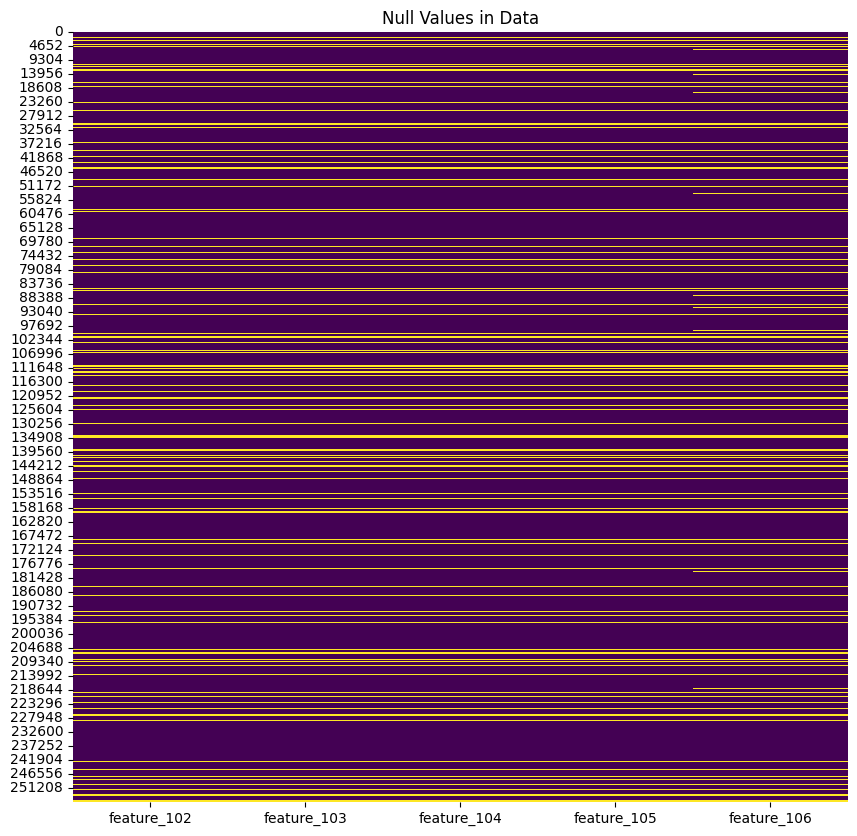

In [8]:
# Создадим тепловую карту для визуализации пропусков
plt.figure(figsize=(10, 10))
sns.heatmap(data[
    missing_columns_df['Column Name'].values.tolist()
    ].isna(), cbar=False, cmap='viridis')
plt.title('Null Values in Data')
plt.show()

Очень похоже на то, что пропуски по этим признакам расположены в одних и тех же строках, кроме некоторого отличия с feature_106.

Бороться с пропусками можно по-разному: заместить значениями показателей центральной тенденции, сгенерировать данные, удалить строки. По-хорошему, серьёзный анализ включает в себя проверку всех способов. Но а мы опробуем здесь генерацию данных с помощью регрессионного метода.

In [9]:
# Список колонок с пропусками
columns_with_nans = missing_columns_df['Column Name'].values.tolist()
data[columns_with_nans].describe()

,feature_102,feature_103,feature_104,feature_105,feature_106
count,218025.000000,218025.000000,218025.000000,218025.000000,213927.000000
mean,59.992574,17.457980,59.184222,241.548387,0.352597
std,194.964719,124.375112,147.625042,359.238223,0.518324
min,-490.000000,-948.000000,-153.000000,-81.000000,-76.600000
25%,4.000000,0.000000,11.000000,34.000000,0.031646
50%,11.000000,1.000000,23.000000,108.000000,0.146341
75%,32.000000,5.000000,51.000000,283.000000,0.752187
max,3278.000000,3278.000000,3278.000000,3278.000000,9.428571


In [10]:
data_copy = data.copy()
verify_copy = verify.copy()

# Функция для заполнения пропусков
def fill_missing_with_regression(original_df1, original_df2, columns_with_nans, target_column):
    # Создаем копию данных из первой таблицы
    df1 = original_df1.copy()

    # Разделяем данные на обучающую и тестовую выборки
    train_data = df1[df1[target_column].notnull()]
    test_data = pd.concat([df1[df1[target_column].isnull()], original_df2[original_df2[target_column].isnull()]], keys=['df1', 'df2'])

    # Определяем признаки и целевую переменную
    X_train = train_data.drop(columns=['ID'] + columns_with_nans)
    y_train = train_data[target_column]

    # Создаем и обучаем модель
    model = CatBoostRegressor(verbose=0)

    # Оценка качества модели с помощью кросс-валидации
    scores = cross_val_score(
        model, X_train, y_train,
        n_jobs=-1, cv=5,
        scoring='neg_root_mean_squared_error'
    )
    print(f'Кросс-валидация для {target_column}: RMSE = {-scores.mean()}')

    # Обучаем модель на всех доступных данных
    model.fit(X_train, y_train)

    # Заполняем пропуски
    if not test_data.empty:
        X_test = test_data.drop(columns=['ID'] + columns_with_nans)
        filled_values = model.predict(X_test)

        # Получаем индексы заполненных значений
        test_indices = test_data.index

        # Заполняем пропуски в оригинальных DataFrame
        for value, idx in zip(filled_values, test_indices):
            if idx[0] == 'df1':
                original_df1.loc[original_df1.index == idx[1], target_column] = value
            else:
                original_df2.loc[original_df2.index == idx[1], target_column] = value

# Заполнение пропусков для каждого признака
for column in columns_with_nans:
    fill_missing_with_regression(data_copy, verify_copy, columns_with_nans, column)

Кросс-валидация для feature_102: RMSE = 143.196549198904
Кросс-валидация для feature_103: RMSE = 69.32459390497452
Кросс-валидация для feature_104: RMSE = 75.99690259899991
Кросс-валидация для feature_105: RMSE = 169.82633112374583
Кросс-валидация для feature_106: RMSE = 0.40003599524780525


In [11]:
# Скопируем данные для базового решения
baseline_data = data.copy()
# Заполним пропуски средними 
baseline_data.fillna(baseline_data.mean(), inplace=True)

Разделим данные на X и y.

In [15]:
# Разделение данных на признаки и целевую переменную
X_lin = baseline_data.drop(['ID', 'target'], axis=1)
y_lin = baseline_data['target']

In [16]:
from sklearn.neighbors import LocalOutlierFactor

In [17]:
clf = LocalOutlierFactor(n_jobs=-1).fit_predict(X_lin)
pd.Series(clf).value_counts()

 1    246600
-1      9220
Name: count, dtype: int64

In [24]:
X_lin_lof = X_lin[clf == 1]
y_lin_lof = y_lin[clf == 1]

In [26]:
# Разделение на обучающую и тестовую выборки
X_lin_lof_train, X_lin_lof_valid, y_lin_lof_train, y_lin_lof_valid = train_test_split(
    X_lin_lof, y_lin_lof, stratify=y_lin_lof, test_size=0.2, random_state=42
    )

lin_lof_scaler = StandardScaler()
X_lin_lof_train_scaled = lin_lof_scaler.fit_transform(X_lin_lof_train)
X_lin_lof_valid_scaled = lin_lof_scaler.transform(X_lin_lof_valid)

In [ ]:
# Разделение на обучающую и тестовую выборки
X_lin_train, X_lin_valid, y_lin_train, y_lin_valid = train_test_split(
    X_lin_lof, y_lin, stratify=y_lin, test_size=0.2, random_state=42
    )

lin_scaler = StandardScaler()
X_lin_train_scaled = lin_scaler.fit_transform(X_lin_train)
X_lin_valid_scaled = lin_scaler.transform(X_lin_valid)

In [13]:
# Разделение на обучающую и тестовую выборки
X_lin_train, X_lin_valid, y_lin_train, y_lin_valid = train_test_split(
    X_lin, y_lin, stratify=y_lin, test_size=0.2, random_state=42
    )

lin_scaler = StandardScaler()
X_lin_train_scaled = lin_scaler.fit_transform(X_lin_train)
X_lin_valid_scaled = lin_scaler.transform(X_lin_valid)

In [14]:
# generative filling
X_gf = data_copy.drop(['ID', 'target'], axis=1)
y_gf = data_copy['target']

In [15]:
# Разделение на обучающую и тестовую выборки
X_gf_train, X_gf_valid, y_gf_train, y_gf_valid = train_test_split(
    X_gf, y_gf, stratify=y_gf, test_size=0.2, random_state=42
    )

gf_scaler = StandardScaler()
X_gf_train_scaled = gf_scaler.fit_transform(X_gf_train)
X_gf_valid_scaled = gf_scaler.transform(X_gf_valid)

У нас был дисбаланс в классах, поэтому можно попробовать использовать синтетическое увеличение данных (ADASYN/SMOTE).

SMOTE (Synthetic Minority Over-sampling Technique) создает новые синтетические примеры, интерполируя между существующими примерами. Это позволяет увеличить количество объектов, сохраняя при этом разнообразие данных.

ADASYN (Adaptive Synthetic) генерирует разное количество выборок в зависимости от оценки локального распределения класса, подлежащего избыточной выборке.

In [17]:
# Применение ADASYN
lin_adasyn = ADASYN(random_state=42)
X_lin_adasyn, y_lin_adasyn = lin_adasyn.fit_resample(X_lin, y_lin)
print("Распределение классов до ADASYN:   ", Counter(y_lin))
print("Распределение классов после ADASYN:", Counter(y_lin_adasyn))

Распределение классов до ADASYN:    Counter({0: 205310, 1: 50510})
Распределение классов после ADASYN: Counter({0: 205310, 1: 195528})


In [21]:
# Разделение на обучающую и тестовую выборки
X_lin_adasyn_train, X_lin_adasyn_valid, y_lin_adasyn_train, y_lin_adasyn_valid = train_test_split(
    X_lin_adasyn, y_lin_adasyn, test_size=0.2, random_state=42
    )

lin_adasyn_scaler = StandardScaler()
X_lin_adasyn_train_scaled = lin_adasyn_scaler.fit_transform(X_lin_adasyn_train)
X_lin_adasyn_valid_scaled = lin_adasyn_scaler.transform(X_lin_adasyn_valid)

In [19]:
gf_adasyn = ADASYN(random_state=42)
X_gf_adasyn, y_gf_adasyn = gf_adasyn.fit_resample(X_gf, y_gf)
print("Распределение классов до ADASYN:   ", Counter(y_gf))
print("Распределение классов после ADASYN:", Counter(y_gf_adasyn))

Распределение классов до ADASYN:    Counter({0: 205310, 1: 50510})
Распределение классов после ADASYN: Counter({0: 205310, 1: 195677})


In [22]:
# Разделение на обучающую и тестовую выборки
X_gf_adasyn_train, X_gf_adasyn_valid, y_gf_adasyn_train, y_gf_adasynr_valid = train_test_split(
    X_gf_adasyn, y_gf_adasyn, test_size=0.2, random_state=42
    )

gf_adasyn_scaler = StandardScaler()
X_gf_adasyn_train_scaled = gf_adasyn_scaler.fit_transform(X_gf_adasyn_train)
X_gf_adasyn_valid_scaled = gf_adasyn_scaler.transform(X_gf_adasyn_valid)

In [24]:
# Применение SMOTE
lin_smote = SMOTE(random_state=42)
X_lin_smote, y_lin_smote = lin_smote.fit_resample(X_lin, y_lin)
print("Распределение классов до SMOTE:   ", Counter(y_lin))
print("Распределение классов после SMOTE:", Counter(y_lin_smote))

# Разделение на обучающую и тестовую выборки
X_lin_smote_train, X_lin_smote_valid, y_lin_smote_train, y_lin_smote_valid = train_test_split(
    X_lin_smote, y_lin_smote, test_size=0.2, random_state=42
    )

lin_smote_scaler = StandardScaler()
X_lin_smote_train_scaled = lin_smote_scaler.fit_transform(X_lin_smote_train)
X_lin_smote_valid_scaled = lin_smote_scaler.transform(X_lin_smote_valid)

Распределение классов до SMOTE:    Counter({0: 205310, 1: 50510})
Распределение классов после SMOTE: Counter({0: 205310, 1: 205310})


In [25]:
gf_smote = SMOTE(random_state=42)
X_gf_smote, y_gf_smote = gf_smote.fit_resample(X_gf, y_gf)
print("Распределение классов до SMOTE:   ", Counter(y_gf))
print("Распределение классов после SMOTE:", Counter(y_gf_smote))

# Разделение на обучающую и тестовую выборки
X_gf_smote_train, X_gf_smote_valid, y_gf_smote_train, y_gf_smote_valid = train_test_split(
    X_gf_smote, y_gf_smote, test_size=0.2, random_state=42
    )

gf_smote_scaler = StandardScaler()
X_gf_smote_train_scaled = gf_smote_scaler.fit_transform(X_gf_smote_train)
X_gf_smote_valid_scaled = gf_smote_scaler.transform(X_gf_smote_valid)

Распределение классов до SMOTE:    Counter({0: 205310, 1: 50510})
Распределение классов после SMOTE: Counter({0: 205310, 1: 205310})


In [27]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_lin), y=y_lin)
class_weights_dict = {i: cw for i, cw in enumerate(class_weights)}

## Моделирование

In [28]:
def get_metrics(model, X_train, X_valid, y_train, y_valid, train_metrics=True):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    
    train_pred_proba = model.predict_proba(X_train)[:, 1]
    valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    
    # Расчет roc_auc
    train_roc_auc = roc_auc_score(y_train, train_pred_proba)

    # ROC-кривая и коэффициент Джини
    fpr_train, tpr_train, train_thresholds = roc_curve(
        y_train, train_pred_proba
        )
    train_roc_auc_value = auc(fpr_train, tpr_train)
    train_gini_coefficient = 2 * train_roc_auc_value - 1
    
    # Расчет roc_auc
    valid_roc_auc = roc_auc_score(y_valid, valid_pred_proba)

    # ROC-кривая и коэффициент Джини
    fpr_valid, tpr_valid, valid_thresholds = roc_curve(
        y_valid, valid_pred_proba
        )
    valid_roc_auc_value = auc(fpr_valid, tpr_valid)
    valid_gini_coefficient = 2 * valid_roc_auc_value - 1
    
    # Оценка модели
    train_report = classification_report(
        y_train, train_preds, digits=4
        )
    
    valid_report = classification_report(
        y_valid, valid_preds, digits=4
        )
    
    # Вывод результатов
    if train_metrics:
        print(f'Train ROC AUC:   {train_roc_auc:.4f}')
        print(f'Train Gini Coef: {train_gini_coefficient:.4f}')
        print(train_report, '\n')
    
    print(f'Val ROC AUC:   {valid_roc_auc:.4f}')
    print(f'Val Gini Coef: {valid_gini_coefficient:.4f}')
    print(valid_report)
    
    return fpr_valid, tpr_valid, valid_thresholds

#### Baseline LogisticRegression

In [29]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_lin_lof_train_scaled, y_lin_lof_train)

lr_roc_curve = get_metrics(
    lr_model, X_lin_lof_train_scaled, X_lin_lof_valid_scaled,
    y_lin_lof_train, y_lin_lof_valid, train_metrics=False
    )

Val ROC AUC:   0.7722
Val Gini Coef: 0.5445
              precision    recall  f1-score   support

           0     0.8279    0.9691    0.8930     39696
           1     0.5703    0.1690    0.2607      9624

    accuracy                         0.8130     49320
   macro avg     0.6991    0.5690    0.5768     49320
weighted avg     0.7776    0.8130    0.7696     49320

CPU times: total: 12.6 s
Wall time: 12.6 s


#### class weighted

In [72]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(
    solver='liblinear',
    class_weight=class_weights_dict
    )
lr_model.fit(X_lin_train_scaled, y_lin_train)

lr_roc_curve = get_metrics(
    lr_model, X_lin_train_scaled, X_lin_valid_scaled,
    y_lin_train, y_lin_valid, train_metrics=False
    )

Val ROC AUC:   0.7733
Val Gini Coef: 0.5466
              precision    recall  f1-score   support

           0     0.9062    0.7085    0.7953     41062
           1     0.3721    0.7020    0.4864     10102

    accuracy                         0.7073     51164
   macro avg     0.6392    0.7053    0.6408     51164
weighted avg     0.8008    0.7073    0.7343     51164

CPU times: total: 10.7 s
Wall time: 10.7 s


---

#### generative filling

In [136]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_gf_train_scaled, y_gf_train)

lr_roc_curve = get_metrics(
    lr_model, X_gf_train_scaled, X_gf_valid_scaled,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.7689
Test Gini Coef: 0.5379
              precision    recall  f1-score   support

           0     0.8276    0.9681    0.8923     41062
           1     0.5814    0.1803    0.2752     10102

    accuracy                         0.8125     51164
   macro avg     0.7045    0.5742    0.5838     51164
weighted avg     0.7790    0.8125    0.7705     51164

CPU times: total: 13.7 s
Wall time: 13.7 s


#### generative filling + class weighted

In [137]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(
    solver='liblinear',
    class_weight=class_weights_dict
    )
lr_model.fit(X_gf_train_scaled, y_gf_train)

lr_roc_curve = get_metrics(
    lr_model, X_gf_train_scaled, X_gf_valid_scaled,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.7703
Test Gini Coef: 0.5407
              precision    recall  f1-score   support

           0     0.9060    0.7037    0.7922     41062
           1     0.3686    0.7031    0.4837     10102

    accuracy                         0.7036     51164
   macro avg     0.6373    0.7034    0.6379     51164
weighted avg     0.7999    0.7036    0.7313     51164

CPU times: total: 9.94 s
Wall time: 9.63 s


#### ADASYN

In [138]:
%%time
# Инициализация и обучение модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_gf_r_train_scaled, y_gf_r_train)

lr_roc_curve = get_metrics(
    lr_model,
    # Тестируем на исходных данных,
    # обработанных скейлером расширенного набора
    gf_r_scaler.transform(X_gf_train),
    gf_r_scaler.transform(X_gf_valid),
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.7613
Test Gini Coef: 0.5225
              precision    recall  f1-score   support

           0     0.8300    0.9579    0.8894     41062
           1     0.5418    0.2025    0.2949     10102

    accuracy                         0.8087     51164
   macro avg     0.6859    0.5802    0.5921     51164
weighted avg     0.7731    0.8087    0.7720     51164

CPU times: total: 34.5 s
Wall time: 34.4 s


#### MLPClassifier

In [ ]:
%%time
# Инициализация и обучение модели
mlpc = MLPClassifier(
    batch_size=128,
    max_iter=2000,
    n_iter_no_change=30,
    early_stopping=True
)
mlpc.fit(X_gf_r_train_scaled, y_gf_r_train)

mlpc_roc_curve = get_metrics(
    mlpc, 
    gf_r_scaler.transform(X_gf_train), 
    gf_r_scaler.transform(X_gf_valid),
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.8189
Test Gini Coef: 0.6377
              precision    recall  f1-score   support

           0     0.8574    0.9439    0.8986     41062
           1     0.6136    0.3618    0.4552     10102

    accuracy                         0.8290     51164
   macro avg     0.7355    0.6529    0.6769     51164
weighted avg     0.8092    0.8290    0.8110     51164

CPU times: total: 2min 20s
Wall time: 1min 26s


#### KNeighborsClassifier

In [33]:
%%time
# Инициализация объекта
knc = KNeighborsClassifier(n_jobs=-1)

knc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

knc_roc_curve = get_metrics(
    knc, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.9129
Test Gini Coef: 0.8258
              precision    recall  f1-score   support

           0     0.9720    0.7492    0.8462     41062
           1     0.4723    0.9124    0.6224     10102

    accuracy                         0.7814     51164
   macro avg     0.7222    0.8308    0.7343     51164
weighted avg     0.8734    0.7814    0.8020     51164

CPU times: total: 45min 47s
Wall time: 4min 20s


#### DecisionTreeClassifier

In [38]:
%%time
# Инициализация и обучение модели
dtc = DecisionTreeClassifier()

dtc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

dtc_roc_curve = get_metrics(
    dtc, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.9254
Test Gini Coef: 0.8508
              precision    recall  f1-score   support

           0     0.9718    0.9644    0.9681     41062
           1     0.8598    0.8864    0.8729     10102

    accuracy                         0.9490     51164
   macro avg     0.9158    0.9254    0.9205     51164
weighted avg     0.9497    0.9490    0.9493     51164

CPU times: total: 14.5 s
Wall time: 14.6 s


#### BaggingClassifier

In [46]:
%%time
bc = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_jobs=-1,
    random_state=42
)
bc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

bc_roc_curve = get_metrics(
    bc, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.9703
Test Gini Coef: 0.9406
              precision    recall  f1-score   support

           0     0.9561    0.9840    0.9699     41062
           1     0.9264    0.8165    0.8680     10102

    accuracy                         0.9510     51164
   macro avg     0.9413    0.9003    0.9189     51164
weighted avg     0.9503    0.9510    0.9498     51164

CPU times: total: 1.83 s
Wall time: 26.9 s


#### RandomForestClassifier

In [141]:
%%time
# Инициализация и обучение модели
rfc = RandomForestClassifier(n_jobs=-1)

rfc.fit(X_gf_r_train, y_gf_r_train)

rfc_roc_curve = get_metrics(
    rfc, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.9855
Test Gini Coef: 0.9710
              precision    recall  f1-score   support

           0     0.9688    0.9866    0.9776     41062
           1     0.9412    0.8709    0.9047     10102

    accuracy                         0.9638     51164
   macro avg     0.9550    0.9288    0.9412     51164
weighted avg     0.9634    0.9638    0.9632     51164

CPU times: total: 3min 24s
Wall time: 20.3 s


#### ExtraTreesClassifier

In [73]:
%%time
# Инициализация и обучение модели
etc = ExtraTreesClassifier(n_jobs=-1)

etc.fit(X_gf_adasyn_train, y_gf_adasyn_train)

etc_roc_curve = get_metrics(
    etc, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Val ROC AUC:   0.9914
Val Gini Coef: 0.9828
              precision    recall  f1-score   support

           0     0.9666    0.9865    0.9765     41062
           1     0.9402    0.8614    0.8991     10102

    accuracy                         0.9618     51164
   macro avg     0.9534    0.9240    0.9378     51164
weighted avg     0.9614    0.9618    0.9612     51164

CPU times: total: 3min 56s
Wall time: 23.9 s


#### LGBMClassifier

In [145]:
%%time
# Инициализация и обучение модели
lgbmc = LGBMClassifier()

lgbmc.fit(X_gf_r_train, y_gf_r_train)

lgbmc_roc_curve = get_metrics(
    lgbmc, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.8050
Test Gini Coef: 0.6101
              precision    recall  f1-score   support

           0     0.8476    0.9521    0.8968     41062
           1     0.6098    0.3044    0.4061     10102

    accuracy                         0.8242     51164
   macro avg     0.7287    0.6282    0.6515     51164
weighted avg     0.8007    0.8242    0.7999     51164

CPU times: total: 26.3 s
Wall time: 3.25 s


#### HistGradientBoostingClassifier

In [144]:
%%time
# Инициализация и обучение модели
hgbc = HistGradientBoostingClassifier()
# Обучение
hgbc.fit(X_gf_r_train, y_gf_r_train)
# Предсказание и получение метрик
hgbc_roc_curve = get_metrics(
    hgbc, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.8050
Test Gini Coef: 0.6101
              precision    recall  f1-score   support

           0     0.8475    0.9531    0.8972     41062
           1     0.6135    0.3028    0.4055     10102

    accuracy                         0.8247     51164
   macro avg     0.7305    0.6279    0.6513     51164
weighted avg     0.8013    0.8247    0.8001     51164

CPU times: total: 45.9 s
Wall time: 9.35 s


#### XGBClassifier

In [193]:
%%time
# Инициализация и обучение модели
xgbc = XGBClassifier()
# Обучение
xgbc.fit(X_gf_r_train, y_gf_r_train)
# Предсказание и получение метрик
xgbc_roc_curve = get_metrics(
    xgbc, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.8302
Test Gini Coef: 0.6603
              precision    recall  f1-score   support

           0     0.8594    0.9549    0.9046     41062
           1     0.6658    0.3648    0.4713     10102

    accuracy                         0.8384     51164
   macro avg     0.7626    0.6599    0.6880     51164
weighted avg     0.8211    0.8384    0.8191     51164

CPU times: total: 24.8 s
Wall time: 2.65 s


#### CatBoostClassifier

In [146]:
%%time
# Инициализация и обучение модели
cbc = CatBoostClassifier(verbose=0)
# Обучение
cbc.fit(X_gf_r_train, y_gf_r_train)
# Предсказание и получение метрик
cbc_roc_curve = get_metrics(
    cbc, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Test ROC AUC:   0.8419
Test Gini Coef: 0.6838
              precision    recall  f1-score   support

           0     0.8635    0.9647    0.9113     41062
           1     0.7258    0.3799    0.4988     10102

    accuracy                         0.8492     51164
   macro avg     0.7946    0.6723    0.7050     51164
weighted avg     0.8363    0.8492    0.8298     51164

CPU times: total: 3min 48s
Wall time: 24.4 s


Что-то бустинговые алгоритмы разочаровали.

### Optimization

Здесь с optuna подбираются гиперпараметры алгоритмов.

#### Optimized LogisticRegression

In [189]:
# Определение функции для оптимизации
def optuna_lr(trial):
    """Функция, обучающая модель LogisticRegression по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1-weighted
    """
    # Задаем пространство поиска гиперпараметров
    C = trial.suggest_float('C', 1e-5, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    else:
        l1_ratio = None

    solver = trial.suggest_categorical('solver', ['newton-cg', 'newton-cholesky', 'lbfgs', 'liblinear', 'saga'])

    if penalty == 'l1' and solver in ['newton-cg', 'newton-cholesky', 'lbfgs', 'sag']:
        return 0.0 # 'l1' penalty is not supported by these solvers
    elif penalty == 'elasticnet' and solver not in ['saga']:
        return 0.0 # 'elasticnet' penalty is supported only by 'saga' solver
    
    # Инициализация LogisticRegression с оптимизируемыми гиперпараметрами
    clf = LogisticRegression(
        C=C, penalty=penalty, solver=solver,
        l1_ratio=l1_ratio, max_iter=10000,
        random_state=42
    )
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(
        clf, X_lin_train_scaled, y_lin_train, cv=5, scoring="f1_weighted", n_jobs=-1
    ).mean()

    return score


# Создание и запуск оптимизации с отображением прогресса с помощью tqdm
study_lr = optuna.create_study(study_name="lr_opt", direction='maximize')
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Мониторим прогресс оптимизации
with tqdm(total=50, desc="Optimizing") as pbar:
    def update(study, trial):
        pbar.update(1)
    # Ищем лучшую комбинацию гиперпараметров n_trials раз
    study_lr.optimize(optuna_lr, n_trials=50, callbacks=[update])

# Получение оптимальных гиперпараметров
print("Лучшие гиперпараметры:", study_lr.best_params)

# Передаем модели коллекцию оптимальных гиперпараметров
lr_opt = LogisticRegression(
    **study_lr.best_params,
    max_iter=10000,
    random_state=42
)

# Обучение алгоритма на оптимальных параметрах
lr_opt.fit(X_lin_train_scaled, y_lin_train)
# Получить отчет по модели
lr_opt_roc_curve = get_metrics(
    lr_opt, X_lin_train_scaled, X_lin_valid_scaled,
    y_lin_train, y_lin_valid, train_metrics=False
    )

[I 2024-12-05 02:55:52,627] A new study created in memory with name: lr_opt
Optimizing: 100%|██████████| 50/50 [38:48<00:00, 46.58s/it]  


Лучшие гиперпараметры: {'C': 19.106971161547733, 'penalty': 'l2', 'solver': 'newton-cg'}
Test ROC AUC:   0.7719
Test Gini Coef: 0.5438
              precision    recall  f1-score   support

           0     0.8278    0.9686    0.8926     41062
           1     0.5860    0.1808    0.2763     10102

    accuracy                         0.8130     51164
   macro avg     0.7069    0.5747    0.5845     51164
weighted avg     0.7800    0.8130    0.7710     51164



In [ ]:
# Передаем модели коллекцию оптимальных гиперпараметров
lr_opt1 = LogisticRegression(
    **{'C': 19.106971161547733, 'penalty': 'l2', 'solver': 'newton-cg'},
    max_iter=10000,
    class_weight=class_weights_dict,
    random_state=42
)

# Обучение алгоритма на оптимальных параметрах
lr_opt1.fit(X_lin_train_scaled, y_lin_train)
# Получить отчет по модели
lr_opt1_roc_curve = get_metrics(
    lr_opt1, X_lin_train_scaled, X_lin_valid_scaled,
    y_lin_train, y_lin_valid, train_metrics=False
    )

Test ROC AUC:   0.7733
Test Gini Coef: 0.5467
              precision    recall  f1-score   support

           0     0.9062    0.7085    0.7952     41062
           1     0.3720    0.7019    0.4863     10102

    accuracy                         0.7072     51164
   macro avg     0.6391    0.7052    0.6408     51164
weighted avg     0.8007    0.7072    0.7342     51164



#### Optimized DecisionTreeClassifier

In [ ]:
%%time
# Напишем функцию для перебора гиперпараметров
def optuna_dtc(trial):
    """Функция, обучающая модель DecisionTreeClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1
    """
    # Задаем пространствао поиска гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 37)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50, 2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Создаем модель
    model=DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42        
    )   
    # Рассчитаем метрику на кросс-валидации
    score = cross_val_score(
        model, X_gf_adasyn_train, y_gf_adasyn_train, cv=5, scoring="f1", n_jobs=-1
    ).mean()
    return score


# Создание и запуск оптимизации с отображением прогресса с помощью tqdm
study_dtc = optuna.create_study(study_name="dtc_opt", direction='maximize')
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Мониторим прогресс оптимизации
with tqdm(total=50, desc="Optimizing") as pbar:
    def update(study, trial):
        pbar.update(1)
    # Ищем лучшую комбинацию гиперпараметров n_trials раз
    study_dtc.optimize(optuna_dtc, n_trials=50, callbacks=[update])

# Получение оптимальных гиперпараметров
print("Лучшие гиперпараметры:", study_dtc.best_params)

# Передаем модели коллекцию оптимальных гиперпараметров
dtc_opt = DecisionTreeClassifier(
    **study_dtc.best_params,
    random_state=42
)

# Обучение алгоритма на оптимальных параметрах
dtc_opt.fit(X_gf_adasyn_train, y_gf_adasyn_train)
# Получить отчет по модели
dtc_opt_roc_curve = get_metrics(
    dtc_opt, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Optimizing: 100%|██████████| 50/50 [08:17<00:00,  9.95s/it]


Лучшие гиперпараметры: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 50, 'min_samples_leaf': 16}
Test ROC AUC:   0.8335
Test Gini Coef: 0.6670
              precision    recall  f1-score   support

           0     0.8790    0.8951    0.8870     41062
           1     0.5393    0.4993    0.5185     10102

    accuracy                         0.8169     51164
   macro avg     0.7092    0.6972    0.7028     51164
weighted avg     0.8119    0.8169    0.8142     51164

CPU times: total: 26.6 s
Wall time: 8min 28s


#### Optimized RandomForestClassifier

In [51]:
# Напишем функцию для оптимизации
def optuna_rfc(trial):
    """Функция, обучающая модель RandomForest по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1-weighted
    """
    # Задаем пространство поиска гиперпараметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 3, 45),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    # Инициализация RandomForest с оптимизируемыми гиперпараметрами
    clf = RandomForestClassifier(
        **params,
        n_jobs=-1,
        random_state=42
    )
    # Рассчитываем метрику на кросс-валидации
    score = cross_val_score(
        clf, X_gf_adasyn_train, y_gf_adasyn_train,
        cv=3, scoring="f1_weighted", n_jobs=-1
    ).mean()
    
    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_rfc = optuna.create_study(study_name="rfc_opt", direction='maximize')
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Мониторим прогресс оптимизации
n_trials=20
with tqdm(total=n_trials, desc="Optimizing") as pbar:
    def update(study, trial):
        pbar.update()
    # Ищем лучшую комбинацию гиперпараметров n_trials раз
    study_rfc.optimize(optuna_rfc, n_trials=n_trials, callbacks=[update])

# Получение оптимальных гиперпараметров
print("Лучшие гиперпараметры:", study_rfc.best_params)

# Передаем модели коллекцию оптимальных гиперпараметров
rfc_opt = RandomForestClassifier(
    **study_rfc.best_params,
    n_jobs=-1, random_state=42
    )

# Обучение алгоритма на оптимальных параметрах
rfc_opt.fit(X_gf_adasyn_train, y_gf_adasyn_train)
# Получить отчет по модели
rfc_opt_roc_curve = get_metrics(
    rfc_opt, X_gf_train, X_gf_valid,
    y_gf_train, y_gf_valid, train_metrics=False
    )

Optimizing: 100%|██████████| 20/20 [33:00<00:00, 99.03s/it] 


Лучшие гиперпараметры: {'n_estimators': 458, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1}
Test ROC AUC:   0.9849
Test Gini Coef: 0.9697
              precision    recall  f1-score   support

           0     0.9701    0.9868    0.9784     41062
           1     0.9421    0.8764    0.9080     10102

    accuracy                         0.9650     51164
   macro avg     0.9561    0.9316    0.9432     51164
weighted avg     0.9646    0.9650    0.9645     51164



### Thresholding

In [147]:
def get_optim_threshold(roc_curve_data):
    fpr, tpr, thresholds = roc_curve_data

    # Оптимальный порог можно найти, например, по максимизации F1-меры
    f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [148]:
def get_optim_thresh_rep(model, X_valid, y_valid, roc_curve_data):
    optimal_threshold = get_optim_threshold(roc_curve_data)
    valid_preds = model.predict_proba(X_valid)
    optimal_test_predictions = (valid_preds.tolist() >= optimal_threshold).astype(int)
    print(classification_report(y_valid, optimal_test_predictions[:, 1], digits=4))

In [149]:
get_optim_thresh_rep(dtc, X_gf_valid, y_gf_valid, rfc_roc_curve)

              precision    recall  f1-score   support

           0     0.9715    0.9646    0.9680     41062
           1     0.8602    0.8848    0.8723     10102

    accuracy                         0.9489     51164
   macro avg     0.9158    0.9247    0.9202     51164
weighted avg     0.9495    0.9489    0.9491     51164



In [150]:
get_optim_thresh_rep(rfc, X_gf_valid, y_gf_valid, rfc_roc_curve)

              precision    recall  f1-score   support

           0     0.9854    0.9483    0.9665     41062
           1     0.8178    0.9430    0.8760     10102

    accuracy                         0.9473     51164
   macro avg     0.9016    0.9457    0.9212     51164
weighted avg     0.9523    0.9473    0.9486     51164



In [151]:
get_optim_thresh_rep(etc, X_gf_valid, y_gf_valid, rfc_roc_curve)

              precision    recall  f1-score   support

           0     0.9821    0.9565    0.9691     41062
           1     0.8401    0.9291    0.8824     10102

    accuracy                         0.9511     51164
   macro avg     0.9111    0.9428    0.9258     51164
weighted avg     0.9541    0.9511    0.9520     51164



---

## Final

### Final LogReg

In [53]:
%%time

lr_final = LogisticRegression(
    solver='liblinear',
    class_weight=class_weights_dict
    )
lr_final.fit(X_lin_train_scaled, y_lin_train)
lr_final_train_preds = lr_final.predict(X_lin_train_scaled)
print(classification_report(y_lin_train, lr_final_train_preds, digits=4))
lr_final_valid_preds = lr_final.predict(X_lin_valid_scaled)
print(classification_report(y_lin_valid, lr_final_valid_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9069    0.7103    0.7967    164248
           1     0.3741    0.7036    0.4884     40408

    accuracy                         0.7090    204656
   macro avg     0.6405    0.7070    0.6426    204656
weighted avg     0.8017    0.7090    0.7358    204656

              precision    recall  f1-score   support

           0     0.9062    0.7085    0.7953     41062
           1     0.3721    0.7020    0.4864     10102

    accuracy                         0.7073     51164
   macro avg     0.6392    0.7053    0.6408     51164
weighted avg     0.8008    0.7073    0.7343     51164

CPU times: total: 10.5 s
Wall time: 10.5 s


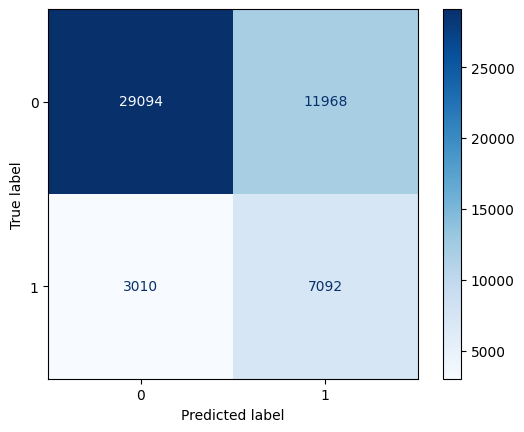

In [56]:
# Вычисляем матрицу путаницы
cm = confusion_matrix(y_lin_valid, lr_final_valid_preds)
# Визуализация матрицы путаницы
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues);

In [57]:
train_preds_proba = lr_final.predict_proba(X_lin_train_scaled)
valid_preds_proba = lr_final.predict_proba(X_lin_valid_scaled)

In [59]:
def get_table(train_probs, valid_probs, y_train, y_valid):
    # Создание DataFrame из вероятностей
    train_df = pd.DataFrame({'Вероятность': train_probs[:, 1], 'target': y_train.values})
    valid_df = pd.DataFrame({'Вероятность': valid_probs[:, 1], 'target': y_valid.values})

    # Определение интервалов
    bins = np.around(np.arange(0.0, 1.1, 0.1), 1).tolist()  # Создание границ интервалов
    labels = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]  # Создание меток для интервалов

    # Разбиение на интервалы
    train_df['Интервал'] = pd.cut(
        train_df['Вероятность'], bins=bins,
        labels=labels, right=True, include_lowest=True
        )
    valid_df['Интервал'] = pd.cut(
        valid_df['Вероятность'], bins=bins,
        labels=labels, right=True, include_lowest=True
        )

    # Группировка по интервалам и подсчет для тренировочной выборки
    train_result = train_df.groupby('Интервал', observed=False).agg(
        Всего_в_группе=('Вероятность', 'size'),
        Кол_во_target_1=('target', lambda x: (x == 1).sum()),
    ).reset_index()

    # Группировка по интервалам и подсчет для валидационной выборки
    valid_result = valid_df.groupby('Интервал', observed=False).agg(
        Всего_в_группе=('Вероятность', 'size'),
        Кол_во_target_1=('target', lambda x: (x == 1).sum()),
    ).reset_index()

    # Переименование столбцов
    train_result.columns = ['Интервал', 'Всего в группе (train)', 'Кол-во target 1 (train)']
    valid_result.columns = ['Интервал', 'Всего в группе (valid)', 'Кол-во target 1 (valid)']

    # Объединение результатов
    final_result = pd.merge(train_result, valid_result, on='Интервал', how='outer')

    # Переименование столбца для вероятности
    final_result['Вероятность'] = final_result['Интервал'].apply(lambda x: f"{x[0]} - {x[1]}")

    # Упорядочивание столбцов
    final_result = final_result[['Вероятность', 'Всего в группе (train)', 'Кол-во target 1 (train)', 
                                'Всего в группе (valid)', 'Кол-во target 1 (valid)']]

    display(final_result)
    
    
get_table(train_preds_proba, valid_preds_proba, y_lin_train, y_lin_valid)

,Вероятность,Всего в группе (train),Кол-во target 1 (train),Всего в группе (valid),Кол-во target 1 (valid)
0,0.0 - 0.1,5500,93,1414,29
1,0.1 - 0.2,29618,1000,7444,259
2,0.2 - 0.3,34930,2342,8563,585
3,0.3 - 0.4,30502,3569,7648,864
4,0.4 - 0.5,28098,4973,7035,1273
5,0.5 - 0.6,25494,6507,6269,1611
6,0.6 - 0.7,20668,7043,5236,1751
7,0.7 - 0.8,15327,6666,3917,1681
8,0.8 - 0.9,9553,5012,2418,1271
9,0.9 - 1.0,4966,3203,1220,778


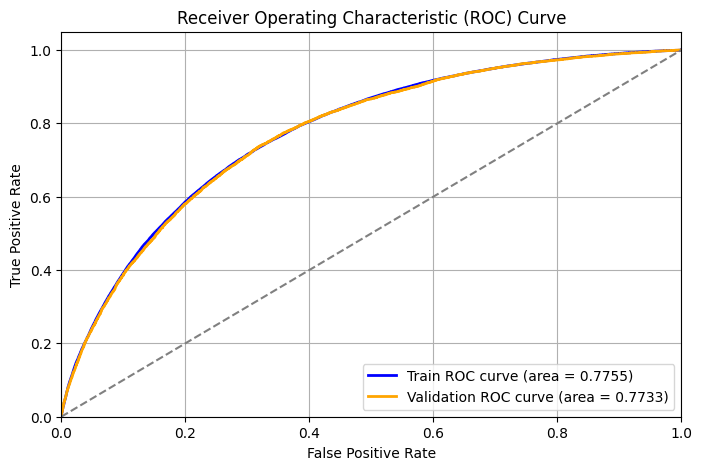

In [60]:
def get_roc_curves(train_probs, valid_probs, y_train, y_valid):
    # Вычисление ROC-кривой и AUC для тренировочной выборки
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probs[:, 1])
    roc_auc_train = auc(fpr_train, tpr_train)

    # Вычисление ROC-кривой и AUC для валидационной выборки
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_probs[:, 1])
    roc_auc_valid = auc(fpr_valid, tpr_valid)

    # Визуализация ROC-кривой
    plt.figure(figsize=(8, 5))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (area = {:.4f})'.format(roc_auc_train))
    plt.plot(fpr_valid, tpr_valid, color='orange', lw=2, label='Validation ROC curve (area = {:.4f})'.format(roc_auc_valid))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайного выбора
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    

get_roc_curves(train_preds_proba, valid_preds_proba, y_lin_train, y_lin_valid)

### Final ETC

In [ ]:
%%time

etc_final = ExtraTreesClassifier(n_jobs=-1)
etc_final.fit(X_gf_r_train, y_gf_r_train)
etc_final_train_preds = etc_final.predict(X_gf_train)
print(classification_report(y_gf_train, etc_final_train_preds, digits=4))
etc_final_valid_preds = etc_final.predict(X_gf_valid)
print(classification_report(y_gf_valid, etc_final_valid_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9675    0.9863    0.9768    164248
           1     0.9395    0.8653    0.9009     40408

    accuracy                         0.9624    204656
   macro avg     0.9535    0.9258    0.9388    204656
weighted avg     0.9620    0.9624    0.9618    204656

              precision    recall  f1-score   support

           0     0.9674    0.9869    0.9770     41062
           1     0.9420    0.8648    0.9017     10102

    accuracy                         0.9628     51164
   macro avg     0.9547    0.9258    0.9394     51164
weighted avg     0.9624    0.9628    0.9622     51164

CPU times: total: 3min 36s
Wall time: 22.8 s


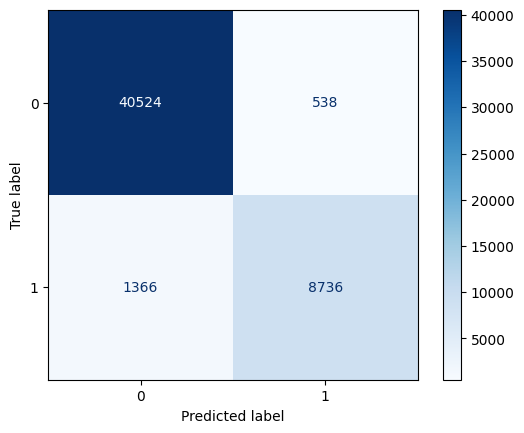

In [153]:
# Вычисляем матрицу путаницы
cm = confusion_matrix(y_gf_valid, etc_final_valid_preds)
# Визуализация матрицы путаницы
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues);

In [154]:
train_preds_proba = etc_final.predict_proba(X_gf_train)
valid_preds_proba = etc_final.predict_proba(X_gf_valid)

In [ ]:
get_table(train_preds_proba, valid_preds_proba, y_gf_train, y_gf_valid)

,Вероятность,Всего в группе (train),Кол-во target 1 (train),Всего в группе (valid),Кол-во target 1 (valid)
0,0.0 - 0.1,146994,681,36836,174
1,0.1 - 0.2,6781,821,1686,216
2,0.2 - 0.3,5556,1172,1396,324
3,0.3 - 0.4,4574,1360,1107,301
4,0.4 - 0.5,3536,1410,865,351
5,0.5 - 0.6,2365,1171,584,300
6,0.6 - 0.7,1389,742,333,176
7,0.7 - 0.8,736,440,179,108
8,0.8 - 0.9,288,195,75,52
9,0.9 - 1.0,32437,32416,8103,8100


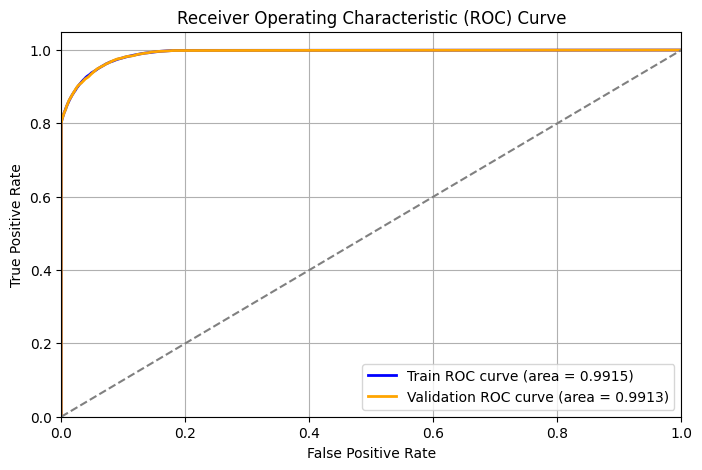

In [ ]:
get_roc_curves(train_preds_proba, valid_preds_proba, y_gf_train, y_gf_valid)

## verify

### by LR

In [ ]:
lr_full = LogisticRegression(
    solver='lbfgs',
    max_iter=1000, n_jobs=-1,
    class_weight=class_weights_dict
    )
lr_full.fit(X_lin, y_lin)

lr_full_pred_proba = lr_full.predict_proba(X_lin)[:, 1]
# Расчет roc_auc
lr_full_roc_auc = roc_auc_score(y_lin, lr_full_pred_proba)
# ROC-кривая и коэффициент Джини
fpr, tpr, thresholds = roc_curve(
    y_lin, lr_full_pred_proba
    )
lr_full_roc_auc_value = auc(fpr, tpr)
lr_full_gini_coefficient = 2 * lr_full_roc_auc_value - 1
print(f'LR ROC AUC:   {lr_full_roc_auc_value:.4f}')
print(f'LR Gini Coef: {lr_full_gini_coefficient:.4f}')
lr_full_data_preds = lr_full.predict(X_lin)
print(classification_report(y_lin, lr_full_data_preds, digits=4))

LR ROC AUC:   0.7302
LR Gini Coef: 0.4605
              precision    recall  f1-score   support

           0     0.8900    0.7031    0.7856    205310
           1     0.3490    0.6469    0.4534     50510

    accuracy                         0.6920    255820
   macro avg     0.6195    0.6750    0.6195    255820
weighted avg     0.7832    0.6920    0.7200    255820



In [67]:
verify_X = verify_copy.drop('ID', axis=1)
lr_full_verify_preds = lr_full.predict(verify_X)
lr_full_verify_probs = lr_full.predict_proba(verify_X)

pd.Series(lr_full_verify_preds).value_counts()

0    31209
1    24821
Name: count, dtype: int64

In [68]:
lr_verify_result = pd.DataFrame(verify['ID'])
lr_verify_result['score'] = lr_full_verify_probs[:, 1]

lr_verify_result.to_csv('lr_verify_result.csv', sep=';', index=False)

### by ETC

In [ ]:
%%time

etc_full = ExtraTreesClassifier(n_jobs=-1)
etc_full.fit(X_gf_adasyn, y_gf_adasyn)
etc_full_data_preds = etc_full.predict(X_gf)
etc_full_pred_proba = etc_full.predict_proba(X_gf)[:, 1]
# Расчет roc_auc
etc_full_roc_auc = roc_auc_score(y_gf, etc_full_pred_proba)
# ROC-кривая и коэффициент Джини
fpr, tpr, thresholds = roc_curve(
    y_gf, etc_full_pred_proba
    )
etc_full_roc_auc_value = auc(fpr, tpr)
etc_full_gini_coefficient = 2 * etc_full_roc_auc_value - 1
print(f'ETC ROC AUC:   {etc_full_roc_auc_value:.4f}')
print(f'ETC Gini Coef: {etc_full_gini_coefficient:.4f}')
etc_full_data_preds = etc_full.predict(X_gf)
print(classification_report(y_gf, etc_full_data_preds, digits=4))

ETC ROC AUC:   1.0000
ETC Gini Coef: 1.0000
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    205310
           1     1.0000    1.0000    1.0000     50510

    accuracy                         1.0000    255820
   macro avg     1.0000    1.0000    1.0000    255820
weighted avg     1.0000    1.0000    1.0000    255820



In [175]:
verify_X = verify_copy.drop('ID', axis=1)
etc_full_verify_preds = etc_full.predict(verify_X)
etc_full_verify_probs = etc_full.predict_proba(verify_X)

In [ ]:
pd.Series(etc_full_verify_preds).value_counts()

0    49114
1     6916
Name: count, dtype: int64

In [ ]:
etc_verify_result = pd.DataFrame(verify['ID'])
etc_verify_result['score'] = etc_full_verify_probs[:, 1]

In [183]:
etc_verify_result.to_csv('etc_verify_result.csv', sep=';', index=False)